In [ ]:
#important libraries to load
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats # for stats.probplot, check QQ plot for normally distributed data
import seaborn as sns
from scipy.stats import f_oneway # one-way ANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tabulate import tabulate #pretty table

In [2]:
file_path = "C:\\Users\\miyoh\\Git_Hub_Work\\Python_data_analysis\\KLK6_ELISA_data_correct_for_dilution.xlsx" #Edit accordingly to where the file is
df= pd.read_excel(file_path, "Sheet2")

In [3]:
df #check that it was read fine

,Combination of dates and plates,Unnamed: 1,Unnamed: 2
0,Value,ID,Group
1,316.5,AD1,MCI_nonProgressor
2,193.5,AD2,MCI_conver_toDem
3,298,AD3,MCI_nonProgressor
4,415,AD4,MCI_conver_toDem
...,...,...,...
389,251.5,AD389,SCD
390,264,AD390,SCD
391,173.5,AD391,SCD
392,256,AD392,SCD


In [4]:
#the columns need to be renamed

df.columns = df.iloc[0] #the new column names are taken from row 1
df = df.drop(df.index[0]) #drop the first row, since we have now saved is as column names

In [5]:
df #check that it worked, new column names should be Value, ID, Group

,Value,ID,Group
1,316.5,AD1,MCI_nonProgressor
2,193.5,AD2,MCI_conver_toDem
3,298,AD3,MCI_nonProgressor
4,415,AD4,MCI_conver_toDem
5,386,AD5,MCI_conver_toDem
...,...,...,...
389,251.5,AD389,SCD
390,264,AD390,SCD
391,173.5,AD391,SCD
392,256,AD392,SCD


In [6]:
#make Value column a numeric value

#In order to do QQ-plots later, I have to turn the Value column into a float (rather than have it as object)
#this way, the other two columns remain intact, without being removed

df = df[["ID", "Group", "Value"]].apply(pd.to_numeric, errors = "ignore")

C:\Users\miyoh\AppData\Local\Temp\ipykernel_44260\3651080441.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df[["ID", "Group", "Value"]].apply(pd.to_numeric, errors = "ignore")


To see if the data are normally distributed, it is possible to run two statistical tests:
- Shapiro-Wilk Test, which is suitable for smaller sample sizes (typically <50), where the null hypothesis is that the data are normally distributed.
- D'Agostino's K-squared test (normaltest), which is based on skewness and kurtosis and is generally suitable for larger sample sizes. Similar to Shapiro-Wilk, a low p-value suggests non-normalilty.

In [7]:
#perform D"Agostino K^2 test

groups = df['Group'].unique() #group by Group

for group_name in groups:
    group_data = df[df["Group"] == group_name]["Value"]
    statistic, p_value = stats.normaltest(group_data) #if we wanted to do Shapiro-Wilk, we would run a shapiro()
    print(f"Normality test for Group {group_name}:")
    print(f" D'Agostino K^2 Statistic: {statistic:.4f}")
    print(f" P-value: {p_value:.4f}")

    alpha = 0.05 #significance level
    if p_value > alpha:
        print(f"Result: Data for Group {group_name} appears to be normally distributed (fail to reject H0)")
    else:
        print(f"Result: Data for group {group_name} does not appear to be normally distributed (reject H0)")
    print("-" * 30)

Normality test for Group MCI_nonProgressor:
 D'Agostino K^2 Statistic: 14.1508
 P-value: 0.0008
Result: Data for group MCI_nonProgressor does not appear to be normally distributed (reject H0)
------------------------------
Normality test for Group MCI_conver_toDem:
 D'Agostino K^2 Statistic: 28.8070
 P-value: 0.0000
Result: Data for group MCI_conver_toDem does not appear to be normally distributed (reject H0)
------------------------------
Normality test for Group SCD:
 D'Agostino K^2 Statistic: 8.6447
 P-value: 0.0133
Result: Data for group SCD does not appear to be normally distributed (reject H0)
------------------------------
Normality test for Group AD:
 D'Agostino K^2 Statistic: 58.2569
 P-value: 0.0000
Result: Data for group AD does not appear to be normally distributed (reject H0)
------------------------------


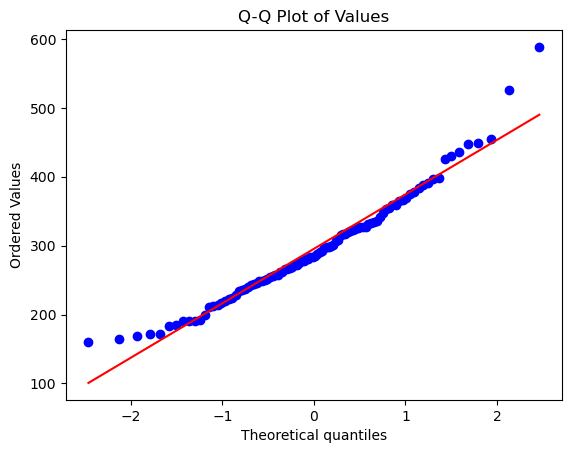

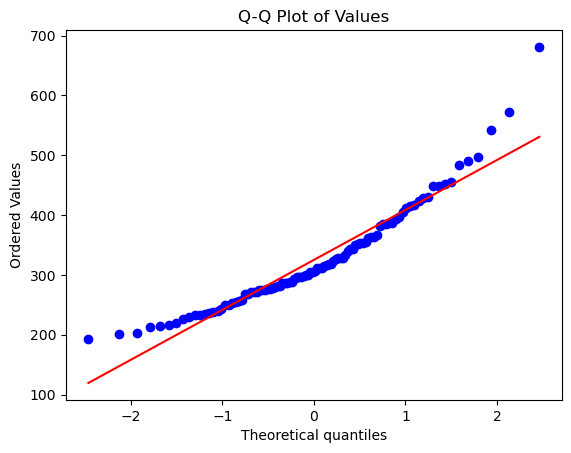

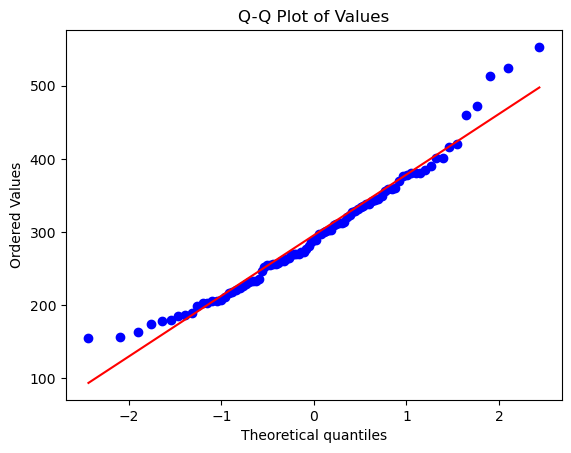

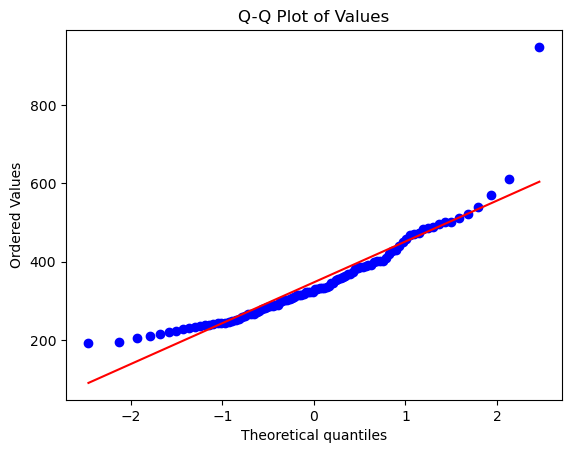

In [8]:
#alternatively, check normal distribution using QQ plot

for group_name in groups:
    group_data = df[df["Group"] == group_name]["Value"]
    stats.probplot(group_data,dist = "norm", plot=plt)
    plt.title("Q-Q Plot of Values")
    plt.show()

In [9]:
#Since our data is not normally distributed, we log2 transform our values
#in a new column, which will be used from now on

df["log2_Value"] = np.log2(df["Value"])

In [10]:
#Check for normality again using the log2 values

for group_name in groups:
    group_data = df[df["Group"] == group_name]["log2_Value"]
    statistic, p_value = stats.normaltest(group_data)
    print(f"Normality test for Group {group_name}:")
    print(f" Shapiro-Wilk Statistic: {statistic:.4f}")
    print(f" P-value: {p_value:.4f}")

    alpha = 0.05 #significance level
    if p_value > alpha:
        print(f"Result: Data for Group {group_name} appears to be normally distributed (fail to reject H0)")
    else:
        print(f"Result: Data for group {group_name} does not appear to be normally distributed (reject H0)")
    print("-" * 30)

Normality test for Group MCI_nonProgressor:
 Shapiro-Wilk Statistic: 0.0006
 P-value: 0.9997
Result: Data for Group MCI_nonProgressor appears to be normally distributed (fail to reject H0)
------------------------------
Normality test for Group MCI_conver_toDem:
 Shapiro-Wilk Statistic: 4.0030
 P-value: 0.1351
Result: Data for Group MCI_conver_toDem appears to be normally distributed (fail to reject H0)
------------------------------
Normality test for Group SCD:
 Shapiro-Wilk Statistic: 0.3784
 P-value: 0.8276
Result: Data for Group SCD appears to be normally distributed (fail to reject H0)
------------------------------
Normality test for Group AD:
 Shapiro-Wilk Statistic: 5.9537
 P-value: 0.0510
Result: Data for Group AD appears to be normally distributed (fail to reject H0)
------------------------------


Prior to ANOVA, we have to check for variances, since they have to be equal

(we have to assume that the variability within each group being compared is roughly the sampe)

To do this, we can do the Bartlett's test, or Levene's test. We have used Levene's test which checks for homogeneity of variances but is less sensitive to departures from normality than Bartlett's test, making it more robust.

In [11]:
#Create 4 groups for stat analysis based on Group column
group_nonprog = df[df["Group"] == "MCI_nonProgressor"]['log2_Value']
group_prog = df[df["Group"] == "MCI_conver_toDem"]['log2_Value']
group_SCD= df[df["Group"] == "SCD"]['log2_Value']
group_AD = df[df["Group"] == "AD"]['log2_Value']

In [18]:
#perform Levene's test
l_statistic, p_value = stats.levene(group_nonprog, group_prog, group_SCD, group_AD)
print(f"Levene's Test Statistic: {l_statistic}")
print(f"Levene's Test p-value: {p_value}")

# Interpretation: If p_value < significance level (e.g., 0.05), reject the null hypothesis
# and conclude that variances are not equal.

print("-"*30) #divider
alpha = 0.05 #significance level
if p_value > alpha:
    print("The variances are equal (fail to reject the H0)")
else:
    print("The variances are not equal (reject the H0)")

Levene's Test Statistic: 0.9401775147699794
Levene's Test p-value: 0.4212065966216285
------------------------------
The variances are equal (fail to reject the H0)


We have to perform the statistics, in this case a one-way ANOVA test (parametric)

In [16]:
#One-way ANOVA

f_statistic, p_value = f_oneway(group_SCD, group_prog, group_AD, group_nonprog)
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

#interpretation:
print("-"*30)
alpha = 0.05 #significance level
if p_value <alpha:
    print("Reject the null hypothesis: There is a significant difference between the groups")
else:
    print("Fail to reject the null hypothesis: there is no significant differences between the groups")

F-statistic: 8.007848303733363
P-value: 3.4289661343842737e-05
------------------------------
Reject the null hypothesis: There is a significant difference between the groups


In order to see which groups are significantly different from each other, a post-hoc test is used. Tukey's is a common choice.

In [ ]:
tukey_result = pairwise_tukeyhsd(endog=df['log2_Value'], groups = df['Group'], alpha = 0.05)
print(tukey_result)
p_values = tukey_result.pvalues

In [ ]:
p_values #check to see what the different p_values are to use later

In [81]:
# Function to add significance bars with custom symbols
def add_sig_bars(ax, group1, group2, p_value, x1, x2, y):
    """Add significance bars with custom symbols and sizes based on p-value."""
    y_offset = 0.2  # Offset for the bar
    ax.plot([x1, x1, x2, x2], [y, y + y_offset, y + y_offset, y], color='black')
    
    # Annotate with different symbols based on p-value
    if p_value < 0.001:
        ax.text((x1 + x2) / 2, y + y_offset + 0.1, '***', fontsize=12, ha='center', color='red')
    elif p_value < 0.01:
        ax.text((x1 + x2) / 2, y + y_offset + 0.1, '**', fontsize=12, ha='center', color='orange')
    elif p_value < 0.05:
        ax.text((x1 + x2) / 2, y + y_offset + 0.1, '*', fontsize=12, ha='center', color='blue')

C:\Users\miyoh\AppData\Local\Temp\ipykernel_39924\1072527576.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(y = df["log2_Value"], x= df["Group"], palette= "RdBu")


(7.105036179299593, 11.0)

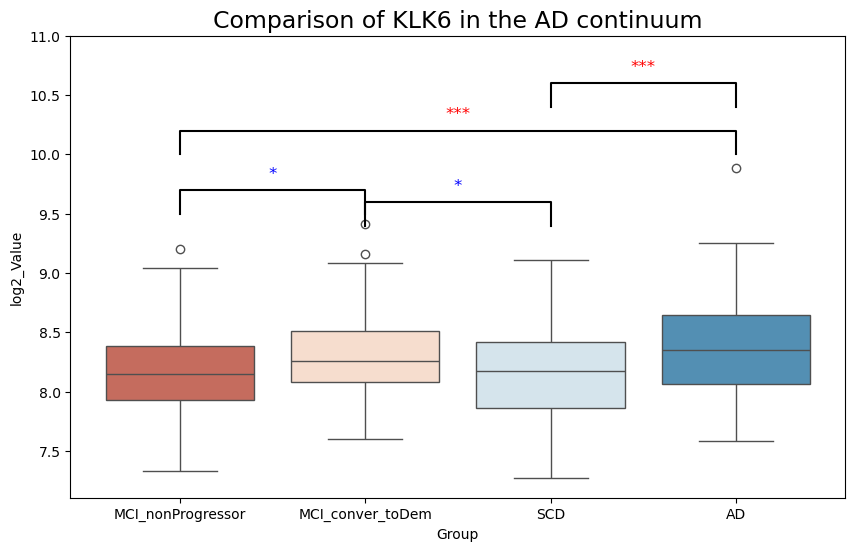

In [85]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(y = df["log2_Value"], x= df["Group"], palette= "RdBu")

#manually check the sig p values
add_sig_bars(ax, "MCI_nonProgessor", "MCI_conver_toDem",p_values[3],0 ,1, 9.5)
add_sig_bars(ax, "AD", "MCI_nonProgessor",p_values[1],0 ,3, 10)
add_sig_bars(ax, "AD", "SCD",p_values[2],2 ,3, 10.4)
add_sig_bars(ax, "SCD", "MCI_conver_toDem",p_values[4],1 ,2, 9.4)


plt.title("Comparison of KLK6 in the AD continuum", fontsize = 17)
plt.ylim(top=11.0)

In this section we create tables for patient statistics

In [41]:
#define for InterQuartile Range
def calculate_iqr(dataframe):
    q1 = dataframe.quantile(0.25)
    q3 = dataframe.quantile(0.75)
    return q3 - q1

def q1(dataframe):
    return dataframe.quantile(0.25)

def q3(dataframe):
    return dataframe.quantile(0.75)


In [ ]:
#Interquartile range
iqr = df.groupby("Group")["Value"].apply(calculate_iqr)
print(iqr)

print("-"*30)
iqr_log2 = df.groupby("Group")["log2_Value"].apply(calculate_iqr)
print(iqr_log2)


Group
AD                   132.500
MCI_conver_toDem      92.750
MCI_nonProgressor     90.375
SCD                  110.000
Name: Value, dtype: float64
------------------------------
Group
AD                   0.581570
MCI_conver_toDem     0.424645
MCI_nonProgressor    0.454181
SCD                  0.557879
Name: log2_Value, dtype: float64


In [ ]:
#Find the Q1 and Q3 by applying the functions
q_25 = df.groupby("Group")["Value"].apply(q1) #25th quantile
print(q_25)

print("-"*30)
q_75 = df.groupby("Group")['Value'].apply(q3) #75th quantile
print(q_75)

print("-"*30)
q_25_log = df.groupby("Group")["log2_Value"].apply(q1)
print(q_25_log)

print("-"*30)
q_75_log = df.groupby("Group")['log2_Value'].apply(q3)
print(q_75_log)

Group
AD                   266.875
MCI_conver_toDem     271.000
MCI_nonProgressor    244.250
SCD                  233.000
Name: Value, dtype: float64
------------------------------
Group
AD                   399.375
MCI_conver_toDem     363.750
MCI_nonProgressor    334.625
SCD                  343.000
Name: Value, dtype: float64
------------------------------
Group
AD                   8.060020
MCI_conver_toDem     8.082149
MCI_nonProgressor    7.932212
SCD                  7.864186
Name: log2_Value, dtype: float64
------------------------------
Group
AD                   8.641590
MCI_conver_toDem     8.506794
MCI_nonProgressor    8.386394
SCD                  8.422065
Name: log2_Value, dtype: float64


In [ ]:
# Group by 'Group' and apply multiple aggregation functions to 'Value' and 'log2_Value
# Save the tables to an Excel file
table1_values = df.groupby('Group').agg({'Value': ['mean', 'median', 'std', 'min', 'max']})
Table1 = pd.concat([table1_values,q_25, q_75], join= "inner", axis=1) #concat to add quartiles
Table1.columns = ["Mean", "Median", "std", "Min", "Max", "Q1", "Q3"]#add headers to q_25 and q_75
print(Table1)
Table1.to_excel("my_table_values.xlsx")

table1_values_log2 = df.groupby('Group').agg({'log2_Value': ['mean', 'median', 'std', 'min', 'max']})
Table1_log2 = pd.concat([table1_values_log2,q_25_log, q_75_log], join= "inner", axis=1) #concat
Table1_log2.columns = ["Mean", "Median", "std", "Min", "Max", "Q1", "Q3"]#add headers to q_25 and q_75
print(Table1_log2)
Table1_log2.to_excel("my_table_log2_values.xlsx")

                         Mean  Median         std    Min    Max       Q1  \
Group                                                                      
AD                 346.995000  326.75  110.669599  192.0  948.0  266.875   
MCI_conver_toDem   325.050000  306.00   85.872895  193.5  681.0  271.000   
MCI_nonProgressor  295.425000  284.50   79.478107  160.5  588.5  244.250   
SCD                295.494624  289.00   83.045937  154.5  553.0  233.000   

                        Q3  
Group                       
AD                 399.375  
MCI_conver_toDem   363.750  
MCI_nonProgressor  334.625  
SCD                343.000  
                       Mean    Median       std       Min       Max        Q1  \
Group                                                                           
AD                 8.377058  8.351948  0.413501  7.584963  9.888743  8.060020   
MCI_conver_toDem   8.299622  8.257386  0.355041  7.596190  9.411511  8.082149   
MCI_nonProgressor  8.156587  8.152276  0.3821